# Assignment 3
## Problem 3: Be Discrete
### author: David Nogales Perez

Code for obtaining the dataset

In [653]:
#install library to import dataset
#!pip3 install pmlb
#from pmlb import fetch_data
#appendicitis_data = fetch_data('appendicitis')
#appendicitis_data.to_csv('appendicitis.csv', index=False)  

Importing necessary libraries and defining important functions

In [654]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns 

from sklearn.model_selection import train_test_split,RandomizedSearchCV,GridSearchCV,cross_val_score
from sklearn.preprocessing import StandardScaler,KBinsDiscretizer
from sklearn.naive_bayes import GaussianNB
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import classification_report,confusion_matrix,ConfusionMatrixDisplay,confusion_matrix

sns.set(rc={'figure.figsize':(10, 7.5)})
sns.set_color_codes("deep")
sns.set_style("whitegrid")

def preprocess_data(X_train, X_test,bins=0,new_strategy=''):
    
    X_train_preprocessed = X_train.copy(deep=True)
    X_test_preprocessed = X_test.copy(deep=True)
    #Discretize variables according to parameters
    if (bins!=0):
        kBinDiscretizer = KBinsDiscretizer(n_bins=bins, encode='onehot-dense', strategy=new_strategy)
        kBinDiscretizer.fit(X_train)
        X_train_preprocessed = kBinDiscretizer.transform(X_train_preprocessed)
        kBinDiscretizer.fit(X_test)
        X_test_preprocessed = kBinDiscretizer.transform(X_test_preprocessed)
    #Scale variables
    scale = StandardScaler()
    X_train_preprocessed = scale.fit_transform(X_train_preprocessed)
    X_test_preprocessed = scale.transform(X_test_preprocessed)
    return X_train_preprocessed,X_test_preprocessed

def generate_result(X_p_train,X_p_test, y_train, y_test,n_neighbors=5):
    models = {
        "naive_bayes":GaussianNB(),
        "logistic_regression":LogisticRegression(),
        "KNN":KNeighborsClassifier(n_neighbors=n_neighbors)
    }
    results_numeric = {}
    results_object = {}
    for name,model in models.items():
        current_model = model.fit(X_p_train,y_train)
        y_pred = current_model.predict(X_p_train)
        model_cvs = cross_val_score(model,X_p_train,y_train,cv=5)
        model_test = current_model.score(X_p_test, y_test)
        model_cls_report = classification_report(y_train, y_pred,output_dict=True)
        model_conf_matrix = confusion_matrix(y_train, y_pred, labels=current_model.classes_)
        result_numeric = {
            "cross_validation_error_avg":model_cvs.mean(),
            "test_error":model_test,
        }
        result_object = {
            "confusion_matrix":model_conf_matrix,
            "classification_report":model_cls_report
        }
        results_numeric[name] = result_numeric
        results_object[name] = result_object

    return results_numeric,results_object

def tune_knn_hyperparameters(X_p_train,y_train):
    param_grid = {'n_neighbors': np.arange(1,20)} 
    knn_best = GridSearchCV(KNeighborsClassifier(), param_grid, cv=5) 
    knn_best.fit(X_p_train, y_train)
    print("GridSearch: n_neightbors ",knn_best.best_params_['n_neighbors'])
    return knn_best.best_params_['n_neighbors']

def results_object_to_dataframe(results_object):
    clfs_dfs = []
    conf_mat_dfs = []
    for _,result in results_object.items():
        conf_mat_df = pd.DataFrame(result["confusion_matrix"])
        clf_rep_df = pd.DataFrame(result["classification_report"])
        clfs_dfs.append(clf_rep_df)
        conf_mat_dfs.append(conf_mat_df)

    clfs_df = pd.concat(clfs_dfs,keys=results_object.keys()).round(2)
    conf_mat_df = pd.concat(conf_mat_dfs,keys=results_object.keys())
    return clfs_df,conf_mat_df

def generate_heatmaps_from_dataframe(df,index_labels,ax):
    indexes = range( len(index_labels))
    for index in indexes:
        sns.heatmap(df.loc[index_labels[index]],annot=True,ax=ax[index])
        ax[index].set_title(index_labels[index])  

In [655]:
#appendicitis_data = fetch_data('appendicitis') 
appendicitis_data = pd.read_csv('appendicitis.csv')
appendicitis_data

,At1,At2,At3,At4,At5,At6,At7,target
0,0.213,0.554,0.207,0.000,0.000,0.749,0.220,1
1,0.458,0.714,0.468,0.111,0.102,0.741,0.436,1
2,0.102,0.518,0.111,0.056,0.022,0.506,0.086,1
3,0.187,0.196,0.105,0.056,0.029,0.133,0.085,1
4,0.236,0.804,0.289,0.111,0.066,0.756,0.241,1
...,...,...,...,...,...,...,...,...
101,0.449,0.875,0.523,0.083,0.076,0.920,0.487,0
102,0.102,0.000,0.022,0.000,0.000,0.000,0.017,0
103,0.409,0.875,0.482,0.306,0.259,0.914,0.443,0
104,0.427,0.804,0.474,0.056,0.048,0.836,0.437,0


###  a) Split data into train and test (60%/40%)

<AxesSubplot:xlabel='target', ylabel='Count'>

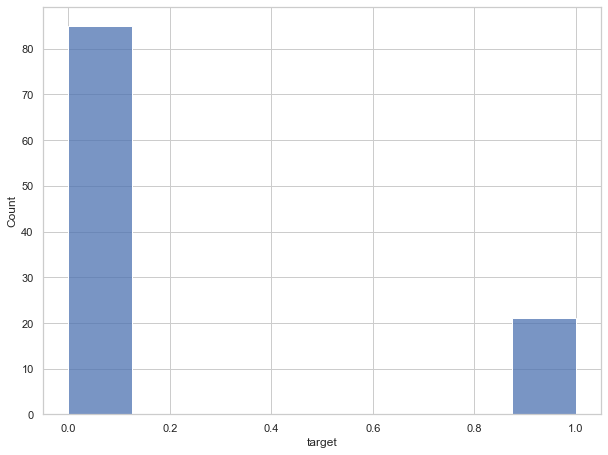

In [730]:
X = appendicitis_data.drop("target",axis=1)
y = appendicitis_data.target
# Split data 60%-40% into training set and test set
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.40, random_state=42)
sns.histplot(y)

The histogram of the target variable reveals the imbalance in our dataset.

###  b) Preprocess adequately for näive bayes, logistic regression and KNN, train and obtain:
 
 - the crossvalidation error
 - the test error
 - confusion matrix
 - classification report

For this step, we first preprocess the data, then explore the KNN hyperparameters and, lastly, we generate the baseline results.

In [725]:
X_p_train,X_p_test = preprocess_data(X_train, X_test)
n_neighbors = tune_knn_hyperparameters(X_p_train,y_train)
results_numeric,results_object = generate_result(X_p_train,X_p_test, y_train, y_test,n_neighbors)

baseline_results = pd.DataFrame(results_numeric)
baseline_results.T.sort_values('test_error').round(3)

GridSearch: n_neightbors  7


,cross_validation_error_avg,test_error
naive_bayes,0.888,0.814
KNN,0.888,0.860
logistic_regression,0.890,0.884


As we can see in our preliminary results, all models have desirable scores. Although Näive Bayes presents some overfitting.

In [658]:
clfs_df,conf_mat_df =results_object_to_dataframe(results_object)
clfs_df

0      1  accuracy  macro avg  weighted avg
naive_bayes         precision   0.94   0.67      0.89       0.80          0.89
                    recall      0.92   0.73      0.89       0.83          0.89
                    f1-score    0.93   0.70      0.89       0.81          0.89
                    support    52.00  11.00      0.89      63.00         63.00
logistic_regression precision   0.93   0.88      0.92       0.90          0.92
                    recall      0.98   0.64      0.92       0.81          0.92
                    f1-score    0.95   0.74      0.92       0.85          0.92
                    support    52.00  11.00      0.92      63.00         63.00
KNN                 precision   0.92   0.70      0.89       0.81          0.89
                    recall      0.94   0.64      0.89       0.79          0.89
                    f1-score    0.93   0.67      0.89       0.80          0.89
                    support    52.00  11.00      0.89      63.00         63.00

The classification reports of each models are very similar, but looking closely, Logistic Regression offers a slighly better precision for both types of patients. Although that might not be that relevant since the number of patients with appendicitis (label 1) is small compared to the patients without it (label 0)

Text(0.5, 0.98, 'Baseline Confusion Matrices')

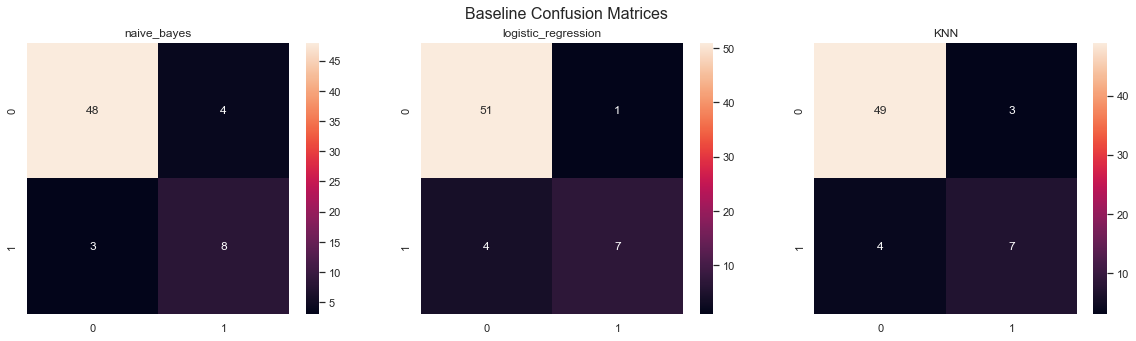

In [659]:
fig, ax = plt.subplots(nrows=1, ncols=3,figsize=(20, 5))
index_labels = list(results_object.keys())
generate_heatmaps_from_dataframe(conf_mat_df,index_labels,ax)
fig.suptitle("Baseline Confusion Matrices", fontsize=16)

The confusion matrices of each of the models show similar results as well as their respective classification reports. In this case we can observe that Näive Bayes, which has the highest recall in the report, predicts 3 false negatives which only differs with the other models by 1. This means that each 10% of the recall is due to a single patient with appendicitis classified without it.

### c) Use KbinsDiscretizer to discretize continuous data.

Apply the following discretizations:
- quantile
- kmeans

Obtaining a discretization into 2,3,4 values.(Use onehot-dense as encoding to set each value as attribute)

Fit the models and compare results. 
- Has this process affected to the quality of the models?
- Which one would you chose and why?



For each strategy and number of bins we preprocess the data with the given strategy and number of bins, obtain the KNN hyperparameters and generate the results for later inspection.

In [660]:
#Discretize variables and generate results for various parameters
strategies = ['quantile','kmeans']
n_bins_list = [2,3,4]
discretization_results = {}
for strategy in strategies:
    aux_results = {}
    for n_bins in n_bins_list:
        X_p_train,X_p_test = preprocess_data(X_train, X_test,bins=n_bins,new_strategy=strategy)
        n_neighbors = tune_knn_hyperparameters(X_p_train,y_train)
        results,_ = generate_result(X_p_train,X_p_test, y_train, y_test,n_neighbors)
        aux_results[n_bins] = results
    discretization_results[strategy] = aux_results


GridSearch: n_neightbors  3
GridSearch: n_neightbors  9
GridSearch: n_neightbors  2
GridSearch: n_neightbors  11
GridSearch: n_neightbors  7
GridSearch: n_neightbors  11


Transform the results to a Dataframe for easier manipulation.

In [675]:
baseline_results_n = baseline_results.T.copy(deep=True)
baseline_results_n.index = pd.MultiIndex.from_product([[0], baseline_results_n.index ], names=['bins', 'model'])
quantile_df = pd.concat({
        k: pd.DataFrame.from_dict(v, 'index') for k, v in discretization_results['quantile'].items()
    }, 
    axis=0)
kmeans_df = pd.concat({
        k: pd.DataFrame.from_dict(v, 'index') for k, v in discretization_results['kmeans'].items()
    }, 
    axis=0)
results_df = pd.concat([ quantile_df, kmeans_df,baseline_results_n ], keys=['quantile','kmeans','baseline'],axis=0)
results_df.index.names = ['strategy','bins','model']
sorted_results = results_df.sort_values('test_error',ascending=False).round(3)
sorted_results

cross_validation_error_avg  test_error
strategy bins model                                                      
baseline 0    logistic_regression                       0.890       0.884
kmeans   4    KNN                                       0.921       0.884
         3    logistic_regression                       0.764       0.884
baseline 0    KNN                                       0.888       0.860
kmeans   3    KNN                                       0.873       0.860
quantile 4    KNN                                       0.905       0.860
         3    logistic_regression                       0.735       0.837
         2    logistic_regression                       0.873       0.814
baseline 0    naive_bayes                               0.888       0.814
kmeans   2    KNN                                       0.873       0.814
              logistic_regression                       0.872       0.814
quantile 3    KNN                                       0.888       0.814
         2    KNN                                       0.873       0.814
kmeans   4    logistic_regression                       0.844       0.791
quantile 2    naive_bayes                               0.779       0.791
         4    logistic_regression                       0.810       0.744
         3    naive_bayes                               0.812       0.744
kmeans   4    naive_bayes                               0.619       0.721
quantile 4    naive_bayes                               0.697       0.698
kmeans   3    naive_bayes                               0.415       0.442
         2    naive_bayes                               0.447       0.419

Looking at the Dataframe with the final results, one can see that the models with better scores are mainly Logistic Regression and KNN with different strategies

Text(0.5, 0.98, 'Cross Validation and Test errors of Trained Models')

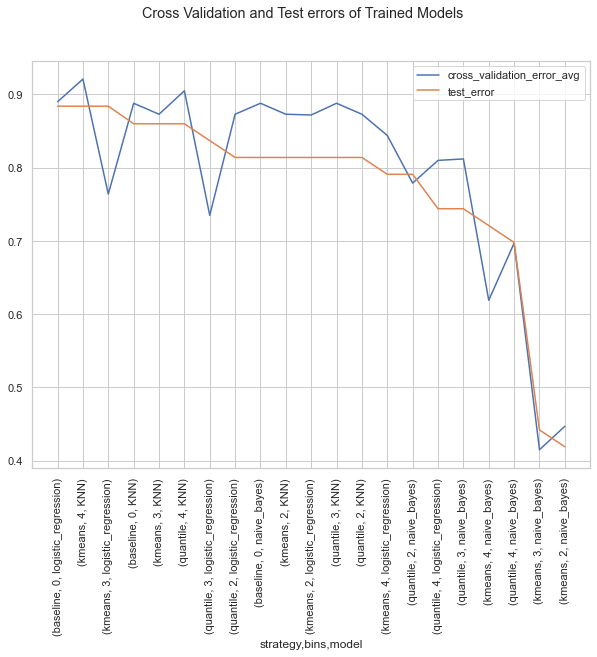

In [708]:
ax = sorted_results.plot(rot=90,xticks=np.arange(0,21))
plt.suptitle("Cross Validation and Test errors of Trained Models")

Looking at the above graph, one can see that several models present some degree of overfitting. Interestingly the baseline model Logistic Regression is the best model overall, with the best score and little overfitting.

Following the Occam's razor principle one could pick the baseline logistic regression model since it's the simplest model overall, but given the sensitive nature of our dataset it would be advisable to explore more alternatives to improve the model.

Text(0.5, 1.0, 'Kmeans Strategy')

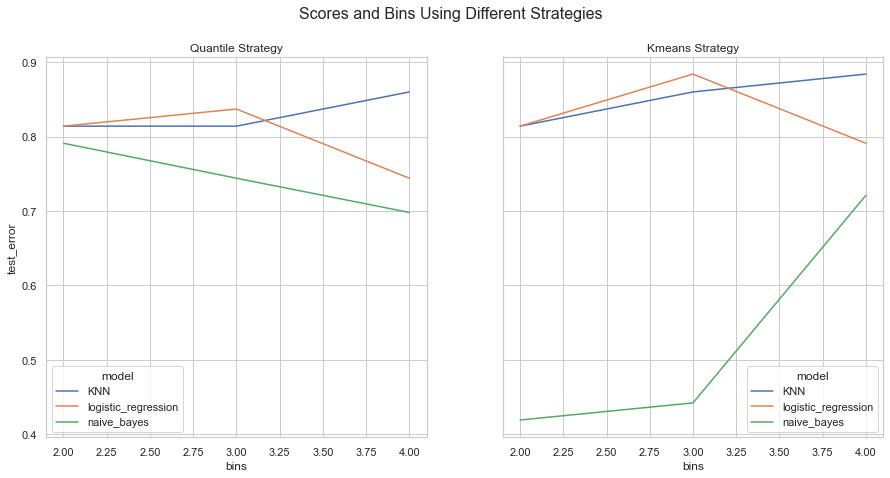

In [722]:
fig, ax = plt.subplots(nrows=1, ncols=2,figsize=(15, 7),sharey=True)
fig.suptitle("Scores and Bins Using Different Strategies", fontsize=16)

df = sorted_results.loc["quantile"].sort_values('model')
sns.lineplot(x='bins', y="test_error", hue="model", data=df,ax=ax[0]).set_title("Quantile Strategy")
df = sorted_results.loc["kmeans"].sort_values('model')
sns.lineplot(x='bins', y="test_error", hue="model", data=df, ax=ax[1]).set_title("Kmeans Strategy")

Here we can see how the binarization affects the different models. For example Näive Bayes using the quantile strategy decreases its accuracy when we increase the number of bins whereas using Kmeans as the discretization strategy follows an inverse trend which with sufficient bins maybe could improve the model but for the bins tested with either strategy we don't achieve better results than the baseline.

For Logistic regression we can see that with 3 bins we find a local maximum in both strategies. Also when using the Kmeans strategy we obtain the same result as the KNN model with less bins.

Lastly, we can see that by discretizing the variables and using more bins we seem to always improve the KNN model.

### d) Considering the interpretability of the models:
- do you think that has advantages to work
with discretized data?
- why?

As we have seen previously, working with discretized data improves the performance of some models in certain conditions (Logistic regression with 3 bins, KNN with more bins) but for others (Bayes) it worsens the performance. 

Furthermore, given that the best model in our tests doesn't even require to discretize data shows that the advantage is minimal to none (at least with the number of bins tested). Maybe exploring a wider range of bins would allow us to be able to obtain some meaningful results. But with the current results it doesn't seem to have a significant impact.


